<h2>Importing Modules</h2>

In [15]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Loading Data</h2>

In [16]:
os.chdir('..')
train = pd.read_csv("D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\input_data\\train.csv")

train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


<h2>Data Cleaning</h2>

In [17]:
train = train.drop(columns=["essay_id"], axis=1)
train.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [18]:
train['full_text_processed'] = train['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))
train['full_text_processed']=train['full_text_processed'].map(lambda x: x.lower())

train['full_text_processed'].head()



<>:1: DeprecationWarning: invalid escape sequence '\.'
<>:1: DeprecationWarning: invalid escape sequence '\.'
C:\Users\HP\AppData\Local\Temp\ipykernel_24516\1779158354.py:1: DeprecationWarning: invalid escape sequence '\.'
  train['full_text_processed'] = train['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    many people have car where they live the thing...
1    i am a scientist at nasa that is discussing th...
2    people always wish they had the same technolog...
3    we all heard about venus the planet without al...
4    dear state senator\r\n\r\nthis is a letter to ...
Name: full_text_processed, dtype: object

<h2>Exploratory Analysis</h2>

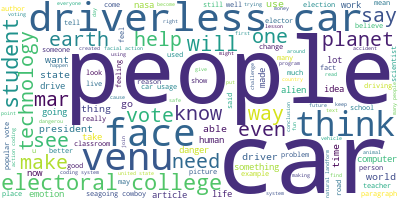

In [19]:
long_string = ','.join(list(train['full_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<h2>Preparing data for LDA analysis</h2>

In [20]:
stop_words = stopwords.words('english')
# we need to add some more stopwords =>
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    # function to convert sentences to words
    # deacc removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    # Function to stop stopwords
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train.full_text_processed.values.tolist()

data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['many', 'people', 'car', 'live', 'thing', 'know', 'car', 'alot', 'thing', 'happen', 'like', 'get', 'accidet', 'smoke', 'car', 'bad', 'breath', 'someone', 'walk', 'vaubangermany', 'dont', 'proble', 'percent', 'vauban', 'families', 'carsand', 'percent', 'sold', 'car', 'move']


In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
# Each tuple represents a word in the document along with its frequency.
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 14), (23, 3), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


<h3>LDA model training</h3>

In [22]:
# Number of topics = 10
num_topics = 5

# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"car" + 0.014*"venus" + 0.013*"cars" + 0.012*"would" + 0.011*"face" + '
  '0.009*"like" + 0.008*"people" + 0.008*"could" + 0.007*"many" + '
  '0.007*"also"'),
 (1,
  '0.014*"people" + 0.011*"would" + 0.011*"could" + 0.009*"face" + '
  '0.008*"cars" + 0.008*"help" + 0.008*"technology" + 0.007*"car" + '
  '0.007*"venus" + 0.007*"like"'),
 (2,
  '0.020*"cars" + 0.018*"would" + 0.015*"people" + 0.014*"car" + 0.012*"venus" '
  '+ 0.010*"driverless" + 0.010*"could" + 0.009*"electoral" + 0.008*"also" + '
  '0.007*"vote"'),
 (3,
  '0.015*"would" + 0.012*"car" + 0.012*"venus" + 0.012*"cars" + 0.011*"people" '
  '+ 0.009*"like" + 0.008*"could" + 0.006*"also" + 0.006*"think" + '
  '0.006*"one"'),
 (4,
  '0.012*"people" + 0.010*"could" + 0.010*"car" + 0.009*"venus" + 0.008*"like" '
  '+ 0.008*"cars" + 0.007*"would" + 0.007*"face" + 0.006*"electoral" + '
  '0.006*"one"')]


<h3>Analyzing LDA model results</h3>

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()

file_name = str(num_topics) +'.html'
LDAvis_data_filepath = os.path.join('D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_' + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_'+ file_name)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.025947 -0.001669       1        1  39.611495
0      0.009162  0.013712       2        1  28.191555
1      0.020329 -0.008526       3        1  17.801287
3     -0.004401 -0.001407       4        1  12.754893
4      0.000858 -0.002110       5        1   1.640770, topic_info=           Term          Freq         Total Category  logprob  loglift
99       people  39439.000000  39439.000000  Default  30.0000  30.0000
171       could  29028.000000  29028.000000  Default  29.0000  29.0000
22          car  40640.000000  40640.000000  Default  28.0000  28.0000
180        face  18838.000000  18838.000000  Default  27.0000  27.0000
498       venus  36694.000000  36694.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
238       would    387.313139  47019.156107   Topic5  -4.9001  -0.6891
163        also    268.146009  22144.589638   Topic5  -5.2678  -0.3038
58          get    232.245409  17854.355976   Topic5  -5.4115  -0.2322
143       think    213.759620  15981.887918   Topic5  -5.4945  -0.2044
356  technology    193.860423  16062.474100   Topic5  -5.5922  -0.3071

[490 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
239        1  0.348905    able
239        2  0.288397    able
239        3  0.246337    able
239        4  0.098387    able
239        5  0.017956    able
...      ...       ...     ...
24738      4  0.325530     wus
24617      4  0.628886  younge
67576      1  0.116412    zeke
67576      2  0.814882    zeke
67576      4  0.116412    zeke

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

<h2>Feature Engineering</h2>

In [24]:
topic_list = lda_model.top_topics(corpus=corpus)
pprint(topic_list[0][0])

[(0.014790683, 'would'),
 (0.01242126, 'car'),
 (0.012134309, 'venus'),
 (0.011998772, 'cars'),
 (0.011149521, 'people'),
 (0.008838413, 'like'),
 (0.008161144, 'could'),
 (0.0064689727, 'also'),
 (0.0058833244, 'think'),
 (0.0056172227, 'one'),
 (0.0055318465, 'earth'),
 (0.0054407218, 'planet'),
 (0.0051599075, 'electoral'),
 (0.0051470925, 'many'),
 (0.0047413628, 'way'),
 (0.0045839143, 'time'),
 (0.004554746, 'new'),
 (0.0045177997, 'world'),
 (0.004413253, 'get'),
 (0.004345062, 'system')]


In [25]:
# pprint(data_words)
relevance_train = pd.DataFrame(columns=['relevancy', 'score'])
relevance_train['score'] = train['score']
relevancy = []
for new_document in data:
    new_bow = lda_model.id2word.doc2bow(new_document.lower().split())
    doc_topics = lda_model.get_document_topics(new_bow, per_word_topics=False)

    most_relevant_topic = max(doc_topics, key=lambda x: x[1])
    relevancy.append(most_relevant_topic[1])

# print(relevancy)
relevance_train['relevancy'] = relevancy


In [26]:
relevance_train.head()

,relevancy,score
0,0.447831,3
1,0.908721,3
2,0.996879,4
3,0.645290,4
4,0.995249,3


<h2>Exporting relevance_train</h2>

In [28]:
relevance_train.to_csv("D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\int_data\\relevance_train.csv")